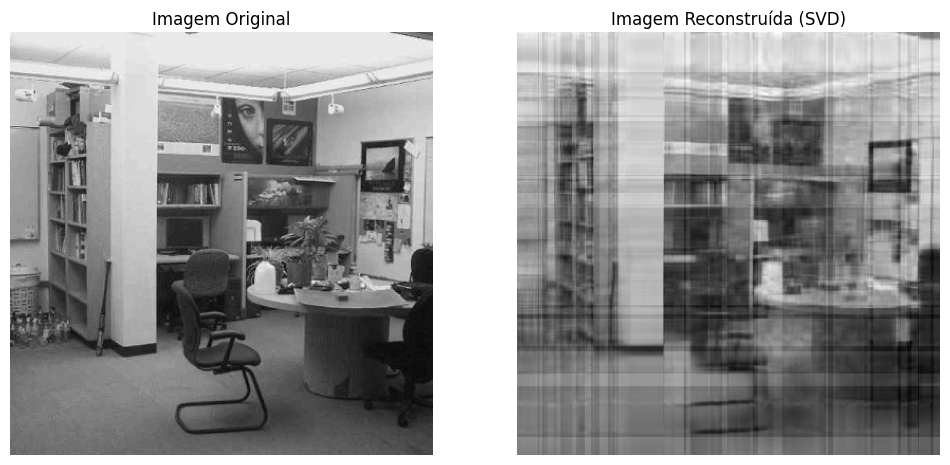

Taxa de Compressão (SVD): 1.24
PSNR (SVD): 84.24 dB


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle

# Função para converter a imagem para precisão dupla (no intervalo [0, 1])
def im2double(im):
    """Converte a imagem para precisão dupla"""
    info = np.iinfo(im.dtype)  # Obter o tipo de dados da imagem
    return im.astype(float) / info.max  # Normaliza para o intervalo [0, 1]

# Função para calcular a decomposição SVD da imagem
def apply_svd(image):
    """Aplica a decomposição SVD na imagem"""
    U, S, VT = np.linalg.svd(image, full_matrices=False)
    return U, S, VT

# Função para quantizar a matriz
def quantize(matrix, num_levels=256):
    """Quantiza a matriz de coeficientes"""
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    quantized_matrix = np.round((matrix - min_val) / (max_val - min_val) * (num_levels - 1))
    return quantized_matrix, min_val, max_val

# Função para desquantizar a matriz
def dequantize(quantized_matrix, min_val, max_val, num_levels):
    """Desquantiza a matriz de coeficientes"""
    matrix = quantized_matrix / (num_levels - 1) * (max_val - min_val) + min_val
    return matrix

# Função para salvar os dados comprimidos em um único arquivo binário
def save_svd_compressed_data(U, S, VT, term_number, filename="svd_compressed_data"):
    """Salva os dados comprimidos (U, S, V) em um único arquivo binário"""
    with open(f"{filename}.bin", "wb") as f:
        np.save(f, term_number)
        np.save(f, U)
        np.save(f, S)
        np.save(f, VT)

# Função para carregar os dados comprimidos de um único arquivo binário
def load_svd_compressed_data(filename="svd_compressed_data"):
    """Carrega os dados comprimidos (U, S, V) de um único arquivo binário"""
    with open(f"{filename}.bin", "rb") as f:
        term_number = np.load(f)
        U = np.load(f)
        S = np.load(f)
        VT = np.load(f)
    return term_number, U, S, VT

# Função para reconstruir a imagem a partir dos dados comprimidos
def reconstruct_image(U, S, VT, term_number):
    """Reconstrói a imagem a partir das matrizes U, S e VT"""
    sigma_matrix = np.diag(S[:term_number])  # Cria a matriz diagonal de Sigma
    reconstructed_img = np.dot(U[:, :term_number], np.dot(sigma_matrix, VT[:term_number, :]))
    return reconstructed_img

# Função para calcular o PSNR (Peak Signal-to-Noise Ratio)
def psnr(original_img, reconstructed_img):
    """Calcula o PSNR (Peak Signal-to-Noise Ratio)"""
    mse = np.mean((original_img - reconstructed_img) ** 2)
    max_pixel = 255.0  # Como a imagem é normalizada para o intervalo [0, 255]
    return 10 * np.log10((max_pixel ** 2) / mse)

# Função para calcular a taxa de compressão
def compression_rate(original_img, compressed_data_filename):
    """Calcula a taxa de compressão"""
    original_size = os.path.getsize(original_img)  # Tamanho do arquivo original
    compressed_size = os.path.getsize(f"{compressed_data_filename}.bin")  # Tamanho do arquivo comprimido
    return original_size / compressed_size

# Carregar a imagem
img = cv2.imread('./unequal.pgm', cv2.IMREAD_GRAYSCALE)
img = im2double(img)  # Normaliza para intervalo [0, 1]

# Aplicar SVD na imagem
U, S, VT = apply_svd(img)

# Definir o número de componentes a serem mantidos (reduzir a dimensionalidade)
term_number = 7  # Aumentar para melhorar a qualidade da imagem, ajustar conforme necessário

# Quantizar os coeficientes
U_quantized, U_min, U_max = quantize(U[:, :term_number], 256)
S_quantized, S_min, S_max = quantize(S[:term_number], 256)
VT_quantized, VT_min, VT_max = quantize(VT[:term_number, :], 256)

# Salvar os dados comprimidos (U, S e V)
save_svd_compressed_data(U_quantized, S_quantized, VT_quantized, term_number)

# Carregar os dados comprimidos
term_number, U_loaded, S_loaded, VT_loaded = load_svd_compressed_data("svd_compressed_data")

# Desquantizar os coeficientes
U_loaded = dequantize(U_loaded, U_min, U_max, 256)
S_loaded = dequantize(S_loaded, S_min, S_max, 256)
VT_loaded = dequantize(VT_loaded, VT_min, VT_max, 256)

# Reconstruir a imagem usando os dados comprimidos
reconstructed_img = reconstruct_image(U_loaded, S_loaded, VT_loaded, term_number)

# Exibir a imagem original e a reconstruída lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Imagem Original")
axes[0].axis('off')

# Reconstruída
axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title("Imagem Reconstruída (SVD)")
axes[1].axis('off')

plt.show()

# Calcular a taxa de compressão e PSNR
rate_svd = compression_rate('./unequal.pgm', "svd_compressed_data")
psnr_svd = psnr(img, reconstructed_img)

print(f"Taxa de Compressão (SVD): {rate_svd:.2f}")
print(f"PSNR (SVD): {psnr_svd:.2f} dB")
